In [1]:
from keras.layers import Dense, Input
from keras.layers import Conv2D, Flatten
from keras.layers import Reshape, Conv2DTranspose
from keras.models import Model
from keras import backend as K
from keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt

(x_train, _), (x_test, _) = mnist.load_data()

x_train = np.reshape(x_train, [-1, 28, 28, 1])
x_test = np.reshape(x_test, [-1, 28, 28, 1])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

Using TensorFlow backend.


In [2]:
noise = np.random.normal(loc=0.5, scale=0.5, size=x_train.shape)
x_train_noise = x_train + noise
noise = np.random.normal(loc=0.5, scale=0.5, size=x_test.shape)
x_test_noise = x_test + noise

# adding noise may exceed normalized pixel values>1.0 or <0.0
# clip pixel values >1.0 to 1.0 and <0.0 to 0.0
x_train_noise = np.clip(x_train_noise, 0., 1.)
x_test_noise = np.clip(x_test_noise, 0., 1.)

inputs = Input(shape=(28,28,1))
x=Conv2D(32,3,activation='relu', strides=2, padding='same')(inputs)
x=Conv2D(64,3,activation='relu', strides=2, padding='same')(x)

shape = K.int_shape(x)
x = Flatten()(x)
latent_z = Dense(16)(x)

encoder = Model(inputs,latent_z)

latent_inputs = Input(shape=(16,))
x = Dense(shape[1] * shape[2] * shape[3])(latent_inputs)
x = Reshape((shape[1], shape[2], shape[3]))(x)
x = Conv2DTranspose(64,3,activation='relu',strides=2,padding='same')(x)
x = Conv2DTranspose(32,3,activation='relu',strides=2,padding='same')(x)
x_tilde= Conv2DTranspose(1,3,activation='sigmoid',padding='same')(x)

decoder = Model(latent_inputs, x_tilde, name='decoder')
autoencoder = Model(inputs,decoder(encoder(inputs)))
autoencoder.compile(loss='mse', optimizer='adam')

autoencoder.fit(x_train_noise,
                x_train,
                validation_data=(x_test_noise, x_test),
                epochs=10,
                batch_size=32)

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 28s 472us/step - loss: 0.0344 - val_loss: 0.0202
Epoch 2/10
60000/60000 [==============================] - 29s 477us/step - loss: 0.0192 - val_loss: 0.0181
Epoch 3/10
60000/60000 [==============================] - 28s 472us/step - loss: 0.0176 - val_loss: 0.0169
Epoch 4/10
60000/60000 [==============================] - 28s 469us/step - loss: 0.0169 - val_loss: 0.0168
Epoch 5/10
60000/60000 [==============================] - 28s 473us/step - loss: 0.0163 - val_loss: 0.0161
Epoch 6/10
60000/60000 [==============================] - 29s 475us/step - loss: 0.0160 - val_loss: 0.0162
Epoch 7/10
60000/60000 [==============================] - 29s 475us/step - loss: 0.0157 - val_loss: 0.0160
Epoch 8/10
60000/60000 [==============================] - 28s 475us/step - loss: 0.0154 - val_loss: 0.0158
Epoch 9/10
60000/60000 [==============================] - 28s 471us/step - loss: 0.0153 - val_

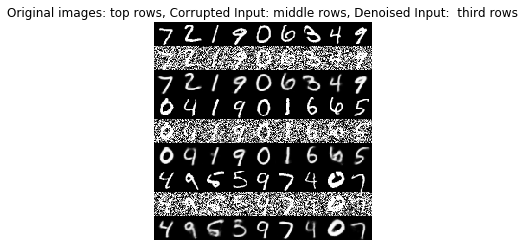

In [9]:
x_decoded = autoencoder.predict(x_test_noise)

imgs = np.concatenate([x_test[:27], x_test_noise[:27], x_decoded[:27]])
imgs = imgs.reshape((9,9, x_test.shape[1],x_test.shape[1]))
imgs = np.vstack(np.split(imgs, 3, axis=1))
imgs = imgs.reshape((9, -1, x_test.shape[1],x_test.shape[1]))
imgs = np.vstack([np.hstack(i) for i in imgs])
imgs = (imgs * 255).astype(np.uint8)
plt.figure()
plt.axis('off')
plt.title('Original images: top rows, '
          'Corrupted Input: middle rows, '
          'Denoised Input:  third rows')
plt.imshow(imgs, interpolation='none', cmap='gray')
plt.show()